<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Joint reactions](02.02-joint-reactions.ipynb) | [Contents](Index.ipynb) | [Analyses](03.00-experts-novices.ipynb) >

# Simple ergonomics indicator

- box-chest distance
- box inclination
- hip-floor distance

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
# from pyosim import Conf
from pyomeca import Markers3d, Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
    describe_clusters,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
class Conf:
    """
    Configuration class in pyosim
    Parameters
    ----------
    project_path : str, Path
        Path to the project
    conf_file : str
        Filename of the configuration file
    """

    def __init__(self, project_path, conf_file="_conf.csv"):
        # load project dir
        self.project_path = Path(project_path)
        if not self.project_path.is_dir():
            raise ValueError(f"{self.project_path} does not exist")
        else:
            print("Project loaded")

        # load project conf
        self.conf_path = self.project_path / conf_file
        if not self.conf_path.is_file():
            raise ValueError(f"{self.conf_path} does not exist")
        else:
            self.project_conf = pd.read_csv(self.conf_path)
            print("Configuration file loaded")

    def get_participants_to_process(self):
        """
        Get a list of participants with the flag 'process' to one or true in project configuration file
        Returns
        -------
        list
        """
        to_process = self.project_conf["process"] == True
        return self.project_conf["participant"].loc[to_process].tolist()

    def get_project_conf_column(self, col):
        """
        Get column(s) from the conf file
        Parameters
        ----------
        col : str
            column to return
        Returns
        -------
        pandas series
        """
        return self.project_conf[col]

    def check_confs(self, verbose=False):
        """check if all participants have a configuration file and update it in the project's configuration file"""

        for index, irow in self.project_conf.iterrows():
            if not irow["process"]:
                continue
            default = self.project_path / irow["participant"] / "_conf.json"
            is_nan = irow["conf_file"] != irow["conf_file"]
            if not is_nan and Path(irow["conf_file"]).is_file():
                if verbose:
                    print(f'{irow["participant"]}: checked')
            if (
                is_nan and default.is_file()
            ) or default.is_file():  # check if nan or file exist in default location
                conf_file = str(default.resolve())
                self.project_conf.loc[index, "conf_file"] = conf_file
                self.update_conf(conf_file, {"conf_file": conf_file})
                if verbose:
                    print(f'{irow["participant"]}: updated in project conf')
            else:
                raise ValueError(
                    f'{irow["participant"]} does not have a configuration file in {irow["conf_file"]}'
                )

        # update conf file
        self.project_conf.to_csv(self.conf_path, index=False)

    @classmethod
    def update_conf(cls, filename, d):
        """
        Update a json file with the dictionary `d`
        Parameters
        ----------
        filename : str
            Path to the json file
        d : dict
            Dictionary to add in configuration file
        """

        def dict_merge(dct, merge_dct):
            """Recursive dict merge. Inspired by :meth:`dict.update()`, instead of
            updating only top-level keys, dict_merge recurses down into dicts nested
            to an arbitrary depth, updating keys. The `merge_dct` is merged into
            `dct`.
            Parameters
            ----------
            dct : dict
                dict onto which the merge is executed
            merge_dct : dict
                dct merged into dct
            """
            from collections import Mapping

            for k, v in merge_dct.items():
                if (
                    k in dct
                    and isinstance(dct[k], dict)
                    and isinstance(merge_dct[k], Mapping)
                ):
                    dict_merge(dct[k], merge_dct[k])
                else:
                    dct[k] = merge_dct[k]
            return dct

        file = open(filename, "r")
        data = json.load(file)

        # data.update(d)
        file = open(filename, "w+")
        json.dump(dict_merge(data, d), file)
        file.close()

    @classmethod
    def get_conf_file(cls, filename):
        """
        Get a configuration file
        Parameters
        ----------
        filename : str
            Path to the json file
        Returns
        -------
        dict
        """
        with open(filename) as file:
            data = json.load(file)
        return data

    def add_conf_field(self, d):
        """
        Update configurations files from a dictionary. The keys should be the participant's pseudo
        Parameters
        ----------
        d : dict
            Dictionary to add in configuration file
        Examples
        -------
        # add some data path
        d = {
            'dapo': {'data': '/home/romain/Downloads/conf-files/DapO/mvc'},
            'davo': {'data': '/home/romain/Downloads/conf-files/DavO/mvc'},
            'fabd': {'data': '/home/romain/Downloads/conf-files/FabD/mvc'}
        }
        project.add_conf_field(d)
        """
        for iparticipant, ivalue in d.items():
            conf_file = self.get_conf_path(iparticipant)
            self.update_conf(conf_file, ivalue)
            print(f"{iparticipant}'s conf file updated")

    def get_conf_path(self, participant):
        """
        Get participant's configuration file path
        Parameters
        ----------
        participant : str
            Participant
        """
        conf_path = self.project_conf[self.project_conf["participant"] == participant][
            "conf_file"
        ].values[0]
        return conf_path

    def get_conf_field(self, participant, field):
        """
        Get participant's specific configuration field
        Parameters
        ----------
        participant : str
            Participant
        field : str, list
            Field(s) to search in the configuration file
        Returns
        -------
        str
        """
        conf_path = self.get_conf_path(participant)
        conf_file = self.get_conf_file(conf_path)

        def get_from_dict(d, keys):
            for k in keys:
                d = d[k]
            return d

        return get_from_dict(conf_file, field)

In [4]:
aws_conf = yaml.safe_load(open("../conf.yml"))
import json

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
conf.check_confs()

Project loaded
Configuration file loaded


/home/romain/miniconda3/envs/pyosim_aws/lib/python3.7/site-packages/ipykernel_launcher.py:102: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


In [5]:
offset = 0.05  # take .5 second before and after onsets
onsets = (
    pd.concat(
        [
            pd.DataFrame(conf.get_conf_field(filename.parent.stem, ["onset"])).T
            for filename in conf.project_path.glob("*/_conf.json")
        ]
    )
    .rename(columns={0: "onset", 1: "offset"})
    .eval("onset = onset - @offset")
    .eval("offset = offset + @offset")
)

onsets.head()

,onset,offset
CamBF12H6_3,1.0765,4.7350
CamBF12H1_1,0.8085,3.5340
CamBF12H1_2,0.8925,3.8740
CamBF12H1_3,0.8360,3.7105
CamBF12H2_1,0.9485,4.4905


In [6]:
def cut_trial(x, onset):
    idx = np.logical_and(
        x.get_time_frames < onset.loc["offset"], x.get_time_frames > onset.loc["onset"]
    )
    return x[..., idx]

## Box-chest distance

In [7]:
box_markers = [
    "boite_avant_gauche_X",
    "boite_avant_gauche_Y",
    "boite_avant_gauche_Z",
    "boite_avant_droit_X",
    "boite_avant_droit_Y",
    "boite_avant_droit_Z",
    "boite_arriere_droit_X",
    "boite_arriere_droit_Y",
    "boite_arriere_droit_Z",
    "boite_arriere_gauche_X",
    "boite_arriere_gauche_Y",
    "boite_arriere_gauche_Z",
]


def box_thorax_distance(x):
    box = pd.concat(
        [x[box_markers].filter(like=i).mean(axis=1).rename(i) for i in ["X", "Y"]],
        axis=1,
    )
    thorax = x.filter(like="STER_").rename(columns=lambda x: x.replace("STER_", ""))
    return (
        np.sqrt(((box - thorax) ** 2).sum(axis=1))
        .replace(0, np.nan)
        .interpolate()
        .rename("box_thorax")
        .to_frame()
    )

In [8]:
height = (
    pd.read_csv(conf.conf_path)
    .query("process == 1")[["participant", "height"]]
    .rename(columns={"height": "p_height"})
)

In [9]:
box_thorax = (
    pd.concat(
        [
            cut_trial(
                Markers3d.from_csv(
                    ifile,
                    header=3,
                    first_row=6,
                    first_column=1,
                    time_column=1,
                    delimiter="\t",
                    last_column_to_remove=1,
                ),
                onsets.loc[ifile.stem],
            )
            .time_normalization()
            .to_dataframe()
            .pipe(box_thorax_distance)
            .assign(filename=ifile.stem)
            if ifile.stem in onsets.index
            else pd.DataFrame()
            for ifile in conf.project_path.glob("*/0_markers/*H2*.trc")
        ]
    )
    .dropna()
    .pipe(parse_conditions)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18 & height == 2")
)

In [10]:
box_thorax.head()

,index,box_thorax,filename,participant,men,height,mass,n_trial
0,0.00,400.633083,CamBF12H2_2,camb,0,2,12,2
1,0.01,398.583078,CamBF12H2_2,camb,0,2,12,2
2,0.02,396.129715,CamBF12H2_2,camb,0,2,12,2
3,0.03,393.047023,CamBF12H2_2,camb,0,2,12,2
4,0.04,389.255438,CamBF12H2_2,camb,0,2,12,2


In [11]:
box_thorax = (
    box_thorax.merge(height, on="participant", how="left")
    .eval("box_thorax = box_thorax / (p_height * 10)")
    .drop("p_height", axis=1)
    .dropna()
)

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [12]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(box_thorax)

Initial
n. participants: 39
----------
men
0    112
1    116
----------
height
2    228
----------
mass
6     114
12    114
----------
men  mass
0    6       55
     12      57
1    6       59
     12      57
----------


In [13]:
balanced_trials = random_balanced_design(
    box_thorax, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
box_thorax = box_thorax.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(box_thorax)

Balanced:
n. participants: 39
----------
men
0    110
1    110
----------
height
2    220
----------
mass
6     110
12    110
----------
men  mass
0    6       55
     12      55
1    6       55
     12      55
----------


### Stats

In [14]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
y = (
    box_thorax.assign(
        participant=lambda x: x["participant"].astype("category").cat.codes
    )
    .set_index(id_vars)
    .unstack()
)
y = y.fillna(y.mean())

y.head()

box_thorax            \
index                                                 0.00      0.01   
filename    participant men height mass n_trial                        
AimQF12H2_1 0           0   2      12   1         0.236063  0.232162   
AimQF12H2_2 0           0   2      12   2         0.222430  0.218224   
AimQF12H2_3 0           0   2      12   3         0.194282  0.189879   
AimQF6H2_1  0           0   2      6    1         0.262006  0.262963   
AimQF6H2_2  0           0   2      6    2         0.255544  0.255164   

                                                                               \
index                                                0.02      0.03      0.04   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.228540  0.225544  0.223592   
AimQF12H2_2 0           0   2      12   2        0.214218  0.210569  0.207750   
AimQF12H2_3 0           0   2      12   3        0.186211  0.182736  0.180168   
AimQF6H2_1  0           0   2      6    1        0.264358  0.266013  0.266863   
AimQF6H2_2  0           0   2      6    2        0.255393  0.256239  0.257784   

                                                                               \
index                                                0.05      0.06      0.07   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.222444  0.222081  0.222744   
AimQF12H2_2 0           0   2      12   2        0.205577  0.204219  0.203849   
AimQF12H2_3 0           0   2      12   3        0.178685  0.178894  0.181271   
AimQF6H2_1  0           0   2      6    1        0.266310  0.264262  0.260824   
AimQF6H2_2  0           0   2      6    2        0.259164  0.259354  0.258258   

                                                                     ...  \
index                                                0.08      0.09  ...   
filename    participant men height mass n_trial                      ...   
AimQF12H2_1 0           0   2      12   1        0.224393  0.225560  ...   
AimQF12H2_2 0           0   2      12   2        0.204882  0.207600  ...   
AimQF12H2_3 0           0   2      12   3        0.186256  0.191648  ...   
AimQF6H2_1  0           0   2      6    1        0.256186  0.250549  ...   
AimQF6H2_2  0           0   2      6    2        0.256006  0.252464  ...   

                                                                               \
index                                                0.91      0.92      0.93   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.212544  0.210570  0.209116   
AimQF12H2_2 0           0   2      12   2        0.211050  0.212313  0.214221   
AimQF12H2_3 0           0   2      12   3        0.201745  0.199996  0.232661   
AimQF6H2_1  0           0   2      6    1        0.280747  0.280349  0.280292   
AimQF6H2_2  0           0   2      6    2        0.271557  0.273717  0.275317   

                                                                               \
index                                                0.94      0.95      0.96   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.208631  0.209041  0.211533   
AimQF12H2_2 0           0   2      12   2        0.215699  0.217462  0.216660   
AimQF12H2_3 0           0   2      12   3        0.199767  0.201102  0.202807   
AimQF6H2_1  0           0   2      6    1        0.280096  0.280473  0.280616   
AimQF6H2_2  0           0   2      6    2        0.276376  0.275012  0.273013   

                                                                               \
index                                                0.97      0.98      0.99   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0          

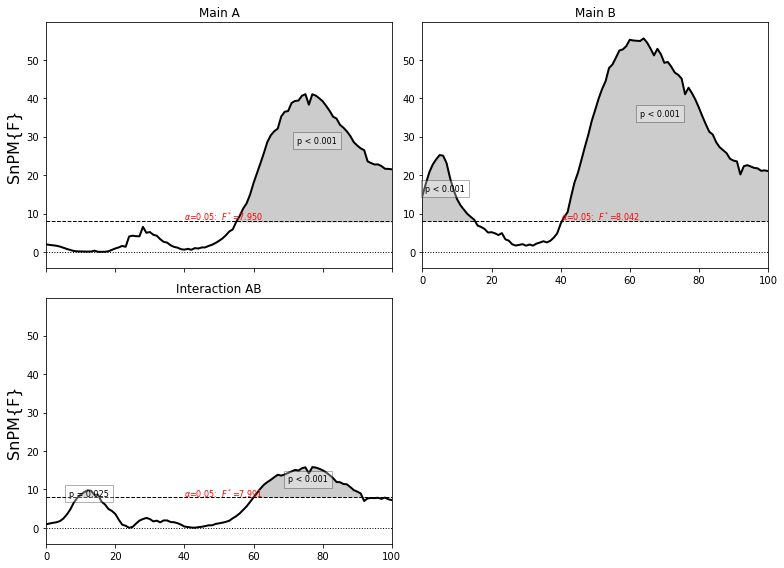

In [15]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [16]:
effect = {
    "Main A": "main sex",
    "Main B": "main mass",
    "Interaction AB": "interaction sex-mass",
}

clusters = get_spm_cluster(spmi, labels=effect, mult=1 / y.shape[1])
clusters

,effect,p,start,end
0,main sex,0,0.545145,0.990099
1,main mass,0.000333333,0,0.150725
2,main mass,0,0.40007,0.990099
3,interaction sex-mass,0.0246667,0.0914136,0.152099
4,interaction sex-mass,0.000333333,0.594602,0.905762


In [17]:
clusters

,effect,p,start,end
0,main sex,0,0.545145,0.990099
1,main mass,0.000333333,0,0.150725
2,main mass,0,0.40007,0.990099
3,interaction sex-mass,0.0246667,0.0914136,0.152099
4,interaction sex-mass,0.000333333,0.594602,0.905762


In [18]:
effect = {"main sex": "men", "main mass": "mass", "interaction sex-mass": "men"}
clusters = describe_clusters(
    clusters, box_thorax.rename(columns=dict(box_thorax="value")), effect
)
clusters

ValueError: not enough values to unpack (expected 2, got 0)

In [19]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [20]:
base = alt.Chart(box_thorax).encode(
    alt.X(
        "index", title="normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(
    alt.Y(
        "mean(box_thorax)",
        title="box-thorax distance (% height)",
        axis=alt.Axis(format="%"),
    )
)
sigma = base.mark_errorband(extent="ci").encode(alt.Y("box_thorax", title=None))
men_scale = alt.Scale(scheme="set1")

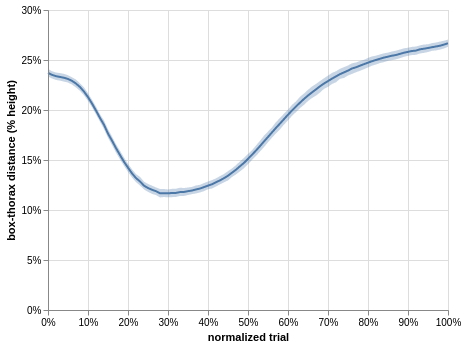

In [21]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

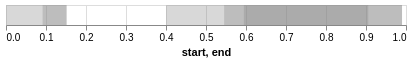

In [22]:
c

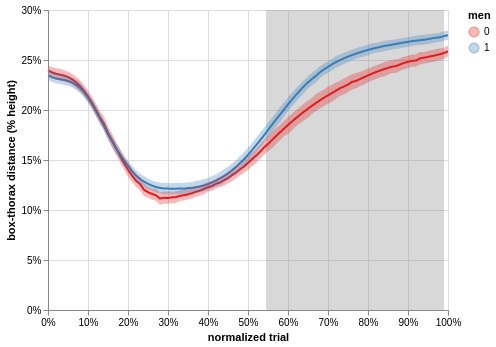

In [23]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

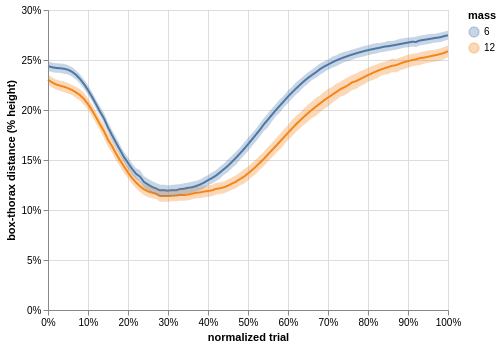

In [24]:
# c.transform_filter('datum.effect == "main mass"') +
(mu + sigma).encode(alt.Color("mass:N"))

In [25]:
clusters.query('effect == "interaction sex-mass"')

,effect,p,start,end
3,interaction sex-mass,0.0246667,0.0914136,0.152099
4,interaction sex-mass,0.000333333,0.594602,0.905762


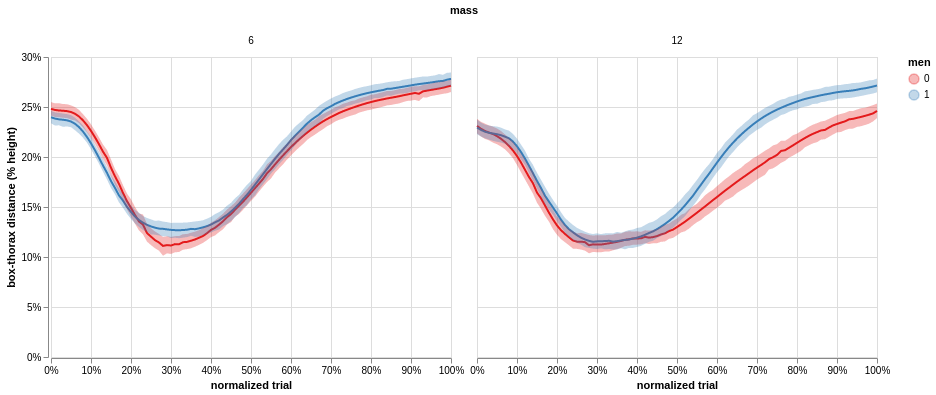

In [26]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## Hip vertical displacement

In [52]:
hip_markers = [
    "ASISl_X",
    "ASISl_Y",
    "ASISl_Z",
    "ASISr_X",
    "ASISr_Y",
    "ASISr_Z",
    "PSISl_X",
    "PSISl_Y",
    "PSISl_Z",
    "PSISr_X",
    "PSISr_Y",
    "PSISr_Z",
]


# def hip_normalized_displacement(x):
#     hip = pd.concat(
#         [x[hip_markers].filter(like=i).mean(axis=1).rename(i) for i in ["X", "Y", "Z"]],
#         axis=1,
#     )
#     hip_first_frame = pd.concat([hip.loc[[0]]] * hip.shape[0], ignore_index=True)
#     return (
#         np.sqrt(((hip - hip_first_frame) ** 2).sum(axis=1))
#         .sum(axis=1)
#         .replace(0, np.nan)
#         .interpolate()
#         .rename("hip_displacement")
#         .to_frame()
#     )


def hip_normalized_displacement(x):
    hip = x[hip_markers].filter(like="Z").mean(axis=1)

    p = x.loc[0, "participant"]
    ref = (
        Markers3d.from_csv(
            f"{project_path}/{p}/0_markers/irssten_{p}d0.trc",
            header=3,
            first_row=6,
            first_column=1,
            time_column=1,
            delimiter="\t",
            last_column_to_remove=1,
        )
        .to_dataframe()[hip_markers]
        .filter(like="Z")
        .mean(axis=1)
        .mean()
    )
    return (
        (hip - ref)
        .replace(0, np.nan)
        .interpolate()
        .rename("hip_displacement")
        .to_frame()
    )


def hip_normalized_displacement(x):
    hip = x[hip_markers].filter(like="Z").mean(axis=1)
    #     ref = hip.loc[0]

    p = x.loc[0, "participant"]
    kwargs = dict(
        header=3,
        first_row=6,
        first_column=1,
        time_column=1,
        delimiter="\t",
        last_column_to_remove=1,
    )
    kwargs[
        "filename"
    ] = f"{conf.project_path}/{p}/0_markers/IRSST_{p[0].upper()}{p[1:-1]}{p[-1].upper()}d0.trc"

    if p == "phii":
        kwargs[
            "filename"
        ] = "/home/romain/Downloads/irsst/phil/0_markers/IRSST_Phild0.trc"
    try:
        ref = (
            Markers3d.from_csv(**kwargs)
            .to_dataframe()[hip_markers]
            .filter(like="Z")
            .mean(axis=1)
            .mean()
        )
    except IndexError:
        kwargs["last_column_to_remove"] = 0
        ref = (
            Markers3d.from_csv(**kwargs)
            .to_dataframe()[hip_markers]
            .filter(like="Z")
            .mean(axis=1)
            .mean()
        )

    return (
        (hip - ref)
        .replace(0, np.nan)
        .interpolate()
        .rename("hip_displacement")
        .to_frame()
    )

In [53]:
hip_displacement = (
    pd.concat(
        [
            cut_trial(
                Markers3d.from_csv(
                    ifile,
                    header=3,
                    first_row=6,
                    first_column=1,
                    time_column=1,
                    delimiter="\t",
                    last_column_to_remove=1,
                ),
                onsets.loc[ifile.stem],
            )
            .time_normalization()
            .to_dataframe()
            .assign(filename=ifile.stem)
            .pipe(parse_conditions)
            .pipe(hip_normalized_displacement)
            .assign(filename=ifile.stem)
            if ifile.stem in onsets.index
            else pd.DataFrame()
            for ifile in conf.project_path.glob("*/0_markers/*H2*.trc")
        ]
    )
    .dropna()
    .pipe(parse_conditions)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18 & height == 2")
)
hip_displacement.sample(10)

,index,hip_displacement,filename,participant,men,height,mass,n_trial
11903,0.86,48.294832,MatRH12H2_3,matr,1,2,12,3
13487,0.54,3.192409,DapOF6H2_3,dapo,0,2,6,3
22415,0.94,43.121077,AmiAF12H2_1,amia,0,2,12,1
18599,0.15,27.276829,NauSF12H2_2,naus,0,2,12,2
28725,0.41,30.301296,DocAH12H2_1,doca,1,2,12,1
8458,0.75,59.914232,SteBF12H2_3,steb,0,2,12,3
7162,0.92,8.695586,DavOH12H2_2,davo,1,2,12,2
11610,0.96,7.142082,MatRH6H2_1,matr,1,2,6,1
22481,0.59,-0.583391,IneAF6H2_2,inea,0,2,6,2
13663,0.28,0.375205,DapOF12H2_2,dapo,0,2,12,2


In [54]:
hip_displacement = (
    hip_displacement.merge(height, on="participant", how="left")
    .eval("hip_displacement = hip_displacement / (p_height * 10)")
    .drop("p_height", axis=1)
    .dropna()
)

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [55]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(hip_displacement)

Initial
n. participants: 39
----------
men
0    112
1    117
----------
height
2    229
----------
mass
6     114
12    115
----------
men  mass
0    6       55
     12      57
1    6       59
     12      58
----------


In [56]:
balanced_trials = random_balanced_design(
    hip_displacement, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
hip_displacement = hip_displacement.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(hip_displacement)

Balanced:
n. participants: 39
----------
men
0    110
1    110
----------
height
2    220
----------
mass
6     110
12    110
----------
men  mass
0    6       55
     12      55
1    6       55
     12      55
----------


### Stats

In [57]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
y = (
    hip_displacement.assign(
        participant=lambda x: x["participant"].astype("category").cat.codes
    )
    .set_index(id_vars)
    .unstack()
)
y = y.fillna(y.mean())

y.head()

hip_displacement            \
index                                                       0.00      0.01   
filename    participant men height mass n_trial                              
AimQF12H2_1 0           0   2      12   1               0.000535  0.001277   
AimQF12H2_2 0           0   2      12   2               0.000732  0.000596   
AimQF12H2_3 0           0   2      12   3              -0.002338 -0.002114   
AimQF6H2_1  0           0   2      6    1               0.001234  0.001087   
AimQF6H2_2  0           0   2      6    2               0.000563  0.000462   

                                                                               \
index                                                0.02      0.03      0.04   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.001618  0.001700  0.001800   
AimQF12H2_2 0           0   2      12   2        0.000460  0.000466  0.000361   
AimQF12H2_3 0           0   2      12   3       -0.001824 -0.001552 -0.001014   
AimQF6H2_1  0           0   2      6    1        0.000988  0.001019  0.001128   
AimQF6H2_2  0           0   2      6    2        0.000322  0.000259  0.000397   

                                                                               \
index                                                0.05      0.06      0.07   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.002015  0.002105  0.002045   
AimQF12H2_2 0           0   2      12   2        0.000231  0.000056 -0.000028   
AimQF12H2_3 0           0   2      12   3       -0.000384  0.000103  0.000503   
AimQF6H2_1  0           0   2      6    1        0.001326  0.001472  0.001593   
AimQF6H2_2  0           0   2      6    2        0.000589  0.000776  0.000996   

                                                                     ...  \
index                                                0.08      0.09  ...   
filename    participant men height mass n_trial                      ...   
AimQF12H2_1 0           0   2      12   1        0.002045  0.002052  ...   
AimQF12H2_2 0           0   2      12   2        0.000039  0.000284  ...   
AimQF12H2_3 0           0   2      12   3        0.000657  0.000628  ...   
AimQF6H2_1  0           0   2      6    1        0.001684  0.001756  ...   
AimQF6H2_2  0           0   2      6    2        0.001140  0.001260  ...   

                                                                               \
index                                                0.91      0.92      0.93   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1       -0.003240 -0.003097 -0.003208   
AimQF12H2_2 0           0   2      12   2        0.003006  0.003236  0.003186   
AimQF12H2_3 0           0   2      12   3        0.017111  0.017226  0.017107   
AimQF6H2_1  0           0   2      6    1        0.006938  0.006850  0.006763   
AimQF6H2_2  0           0   2      6    2        0.006297  0.006451  0.006745   

                                                                               \
index                                                0.94      0.95      0.96   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1       -0.003262 -0.002964 -0.002541   
AimQF12H2_2 0           0   2      12   2        0.003044  0.003127  0.003620   
AimQF12H2_3 0           0   2      12   3        0.016964  0.017030  0.017369   
AimQF6H2_1  0           0   2      6    1        0.006638  0.006469  0.006267   
AimQF6H2_2  0           0   2      6    2        0.006981  0.007128  0.007157   

                                                                               \
index                                                0.97      0.98      0.99   
filename    participant men height mass n_trial         

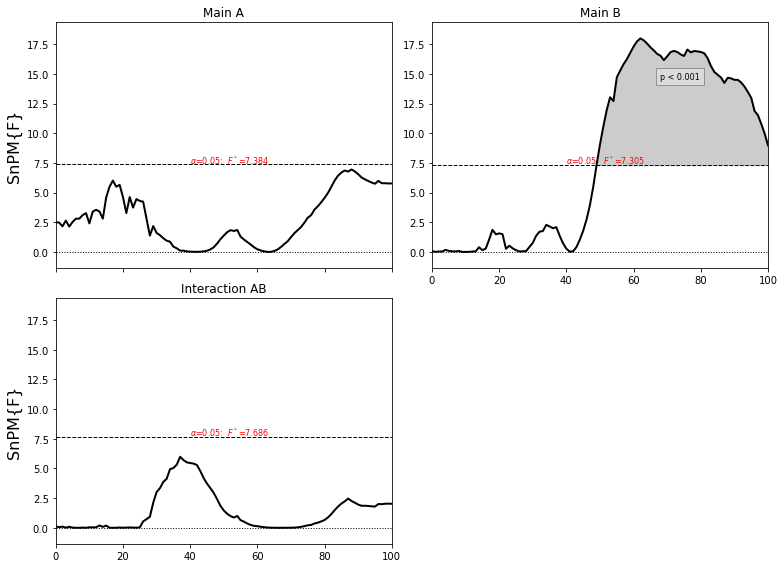

In [58]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [59]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main mass,0,0.484778,0.990099


In [60]:
effect = {"main sex": "men", "main mass": "mass", "interaction sex-mass": "men"}
clusters = describe_clusters(
    clusters, box_thorax.rename(columns=dict(box_thorax="value")), effect
)
clusters

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
0,main mass,0.0,0.48,0.99,12 - 6,0.04,0.65,medium


In [61]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [62]:
base = alt.Chart(hip_displacement).encode(
    alt.X(
        "index", title="normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(
    alt.Y(
        "mean(hip_displacement)",
        axis=alt.Axis(format="%"),
        title="hip vertical displacement (% height)",
    )
)
sigma = base.mark_errorband(extent="ci").encode(alt.Y("hip_displacement", title=None))
men_scale = alt.Scale(scheme="set1")

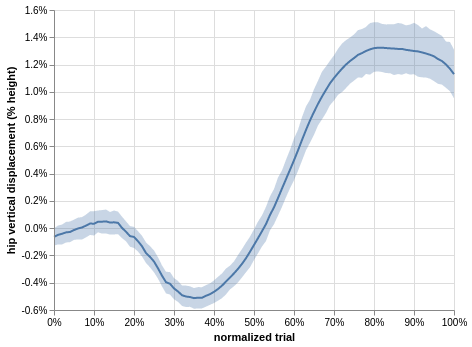

In [63]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

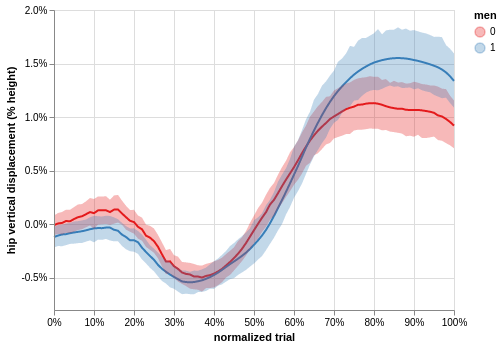

In [64]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

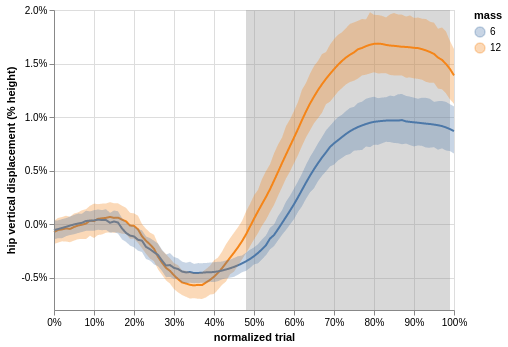

In [65]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

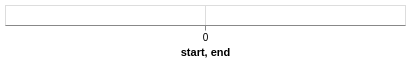

In [66]:
c.transform_filter('datum.effect == "interaction sex-mass"')

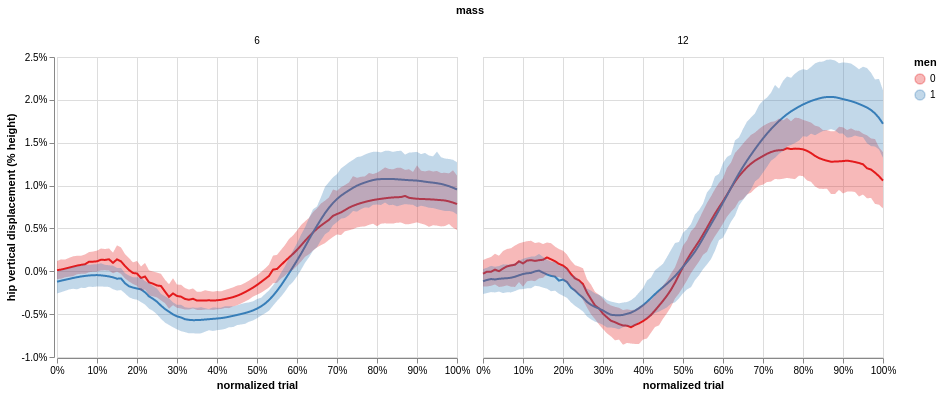

In [67]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## Box inclination

In [32]:
box_incl = (
    pd.concat(
        [
            Analogs3d.from_mot(ifile)
            .time_normalization()
            .to_dataframe()[["box_rotY"]]
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob("*/1_inverse_kinematic/*.mot")
        ]
    )
    .pipe(parse_conditions, suffix="wu_")
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18 & height == 2")
)

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [46]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(box_incl)

Initial
n. participants: 40
----------
men
0    114
1    126
----------
height
2    240
----------
mass
6     120
12    120
----------
men  mass
0    6       57
     12      57
1    6       63
     12      63
----------


In [47]:
balanced_trials = random_balanced_design(
    box_incl, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
box_incl = box_incl.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(box_incl)

Balanced:
n. participants: 40
----------
men
0    114
1    114
----------
height
2    228
----------
mass
6     114
12    114
----------
men  mass
0    6       57
     12      57
1    6       57
     12      57
----------


### Stats

In [48]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
y = (
    box_incl.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y = y.fillna(y.mean())

y.head()

box_rotY                      \
index                                                0.00      0.01      0.02   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2       -0.071158 -0.076242 -0.085452   
VerCF12H2_3 37          0   2      12   3       -0.009264 -0.018573 -0.014573   
VerCF6H2_1  37          0   2      6    1       -0.072524 -0.062117 -0.069048   
VerCF12H2_2 37          0   2      12   2       -0.040455 -0.030781 -0.048211   
VerCF6H2_3  37          0   2      6    3       -0.065679 -0.070749 -0.076233   

                                                                               \
index                                                0.03      0.04      0.05   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2       -0.103708 -0.097241 -0.113162   
VerCF12H2_3 37          0   2      12   3       -0.004224 -0.012667 -0.013660   
VerCF6H2_1  37          0   2      6    1       -0.085744 -0.095541 -0.004661   
VerCF12H2_2 37          0   2      12   2       -0.042907 -0.051386 -0.065951   
VerCF6H2_3  37          0   2      6    3       -0.084797 -0.098515 -0.112677   

                                                                               \
index                                                0.06      0.07      0.08   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2       -0.133976 -0.146747 -0.227633   
VerCF12H2_3 37          0   2      12   3       -0.026019 -0.063381 -0.136831   
VerCF6H2_1  37          0   2      6    1       -0.024527  0.000715  0.058182   
VerCF12H2_2 37          0   2      12   2       -0.052445 -0.080458 -0.044940   
VerCF6H2_3  37          0   2      6    3       -0.158566 -0.213254 -0.313821   

                                                           ...            \
index                                                0.09  ...      0.91   
filename    participant men height mass n_trial            ...             
VerCF6H2_2  37          0   2      6    2       -0.501209  ...  0.300984   
VerCF12H2_3 37          0   2      12   3       -0.194731  ...  0.278481   
VerCF6H2_1  37          0   2      6    1        0.048257  ...  0.346287   
VerCF12H2_2 37          0   2      12   2        0.014924  ...  0.223002   
VerCF6H2_3  37          0   2      6    3       -0.402635  ...  0.359575   

                                                                               \
index                                                0.92      0.93      0.94   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2        0.297583  0.286589  0.105273   
VerCF12H2_3 37          0   2      12   3        0.252241  0.270395  0.266160   
VerCF6H2_1  37          0   2      6    1        0.323573  0.338829  0.324097   
VerCF12H2_2 37          0   2      12   2        0.213945  0.178290  0.187304   
VerCF6H2_3  37          0   2      6    3        0.323452  0.334351  0.294551   

                                                                               \
index                                                0.95      0.96      0.97   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2        0.277483  0.282854  0.286339   
VerCF12H2_3 37          0   2      12   3        0.250519  0.250093  0.250847   
VerCF6H2_1  37          0   2      6    1        0.299324  0.312567  0.298606   
VerCF12H2_2 37          0   2      12   2        0.183285  0.195693  0.196291   
VerCF6H2_3  37          0   2      6    3        0.344698  0.309033  0.268882   

                                                                               
index                                                0.98      0.99      1.00  
filename    participant men height 

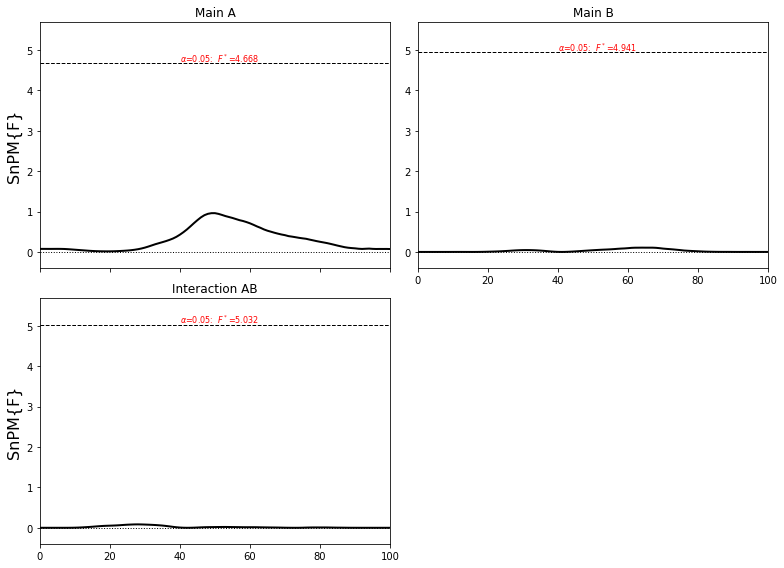

In [49]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [59]:
base = alt.Chart(box_incl).encode(
    alt.X("index", title="normalized trial", axis=alt.Axis(format="%"))
)
mu = base.mark_line().encode(alt.Y("mean(box_rotY)", title="box inclination (mm)"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("box_rotY", title=None))

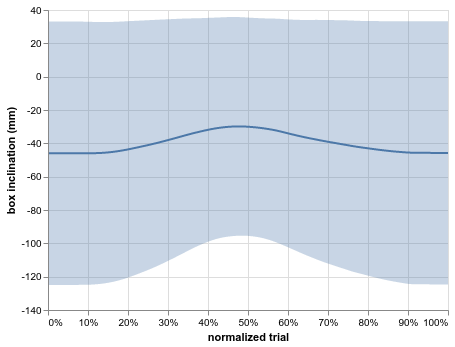

In [60]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

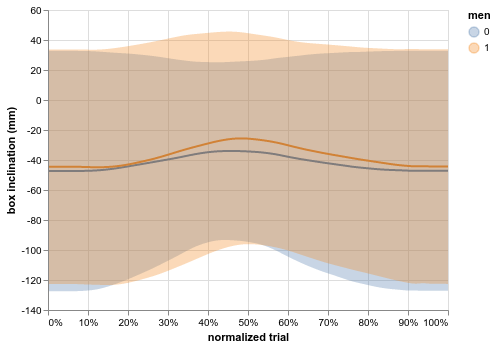

In [61]:
(mu + sigma).encode(alt.Color("men:N"))

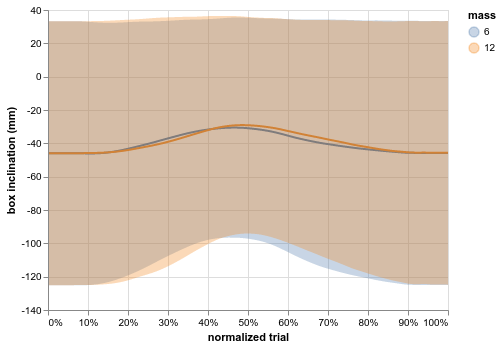

In [62]:
(mu + sigma).encode(alt.Color("mass:N"))

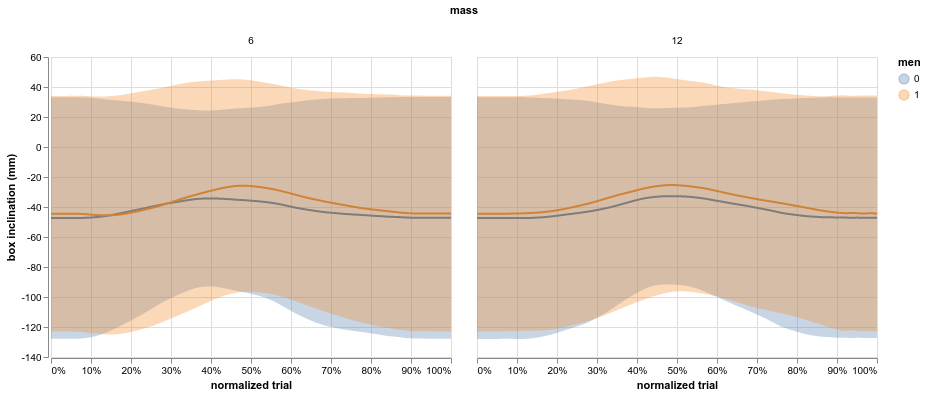

In [63]:
(mu + sigma).encode(alt.Color("men:N")).facet(column="mass")

<!--NAVIGATION-->
< [Joint reactions](02.02-joint-reactions.ipynb) | [Contents](Index.ipynb) | [Analyses](03.00-experts-novices.ipynb) >